In [1]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as torch_F
from jetbotData import get_train_val_dataloader
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os
# tensorboard
from torch.utils.tensorboard import SummaryWriter
import pickle
# import tensorboardX

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


In [3]:
def save_model(model,path="model.pth"):
    torch.save(model.state_dict(), path)
def load_model(model,path="model.pth"):
    model.load_state_dict(torch.load(path))
def create_mobile_model():
    model=torchvision.models.segmentation.lraspp_mobilenet_v3_large(num_classes=4)
    return model

x=torch.randn(1,3,128,128).cuda()
m=create_mobile_model().cuda()
y=m(x)
print(y['out'].shape)

torch.Size([1, 4, 128, 128])


In [4]:
def label_to_rgb(label_tensor, label_colors):
    height, width = label_tensor.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    label_np = label_tensor.cpu().numpy()
    for label, color in label_colors.items():
        mask = label_np == label
        rgb_image[mask] = color

    return rgb_image
label_colors = {
    0: [0, 0, 0],       # black -> background
    1: [128, 0, 0],     # dark red -> road
    2: [0, 128, 0],     # light green -> landmark solid
    3: [128, 128, 0]    # green -> landmark dashed
}

In [5]:
m=create_mobile_model()
save_model(m)
load_model(m)
m=m.cuda()


In [15]:
def acc(out_img,label):
    out=torch.argmax(out_img,dim=1)
    label_out=label.argmax(dim=1)
    return (out==label_out).float().mean()

In [18]:
# hyperparameters
device = 'cuda'
epochs = 300
lr=1e-3
lr_end=1e-5

# dataset
dataset_name = "roadlane"
dataloaders, dataset_size = get_train_val_dataloader(4,0, type=dataset_name)
train_dataloader = dataloaders["train"]
val_dataloader = dataloaders["val"]
save_dir = f'checkpoints/mobile/{dataset_name}/'
os.makedirs(save_dir, exist_ok=True)
os.makedirs('out', exist_ok=True)
# loss and optimizer
weight=torch.tensor([1,1,10,10]).float().to(device)
criterion = nn.CrossEntropyLoss(weight)
optimizer = optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr_end)
# tensorboard
tb = SummaryWriter(f'runs/{dataset_name}')

print("dataset size:", dataset_size)

# TODO training loop
min_val_loss = float('inf')
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]


with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        # ================== training ==================
        m.train()
        running_loss = 0.0
        for iter, batch in enumerate(train_dataloader):
            images = batch['img'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = m(images)['out']
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss  = running_loss / len(train_dataloader)
        # record the loss
        tb.add_scalar('Loss/train', avg_train_loss, epoch)
        train_loss.append(avg_train_loss)
        train_acc.append(acc(outputs,labels).item())
        # ================== validation ==================
        m.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_dataloader:
                X_val = val_batch["img"].to(device)
                y_val = val_batch["label"].to(device)
                outputs_val = m(X_val)['out']
                running_val_loss += criterion(outputs_val, y_val).item()
                
                # svae the tmp output
                for i,img_out in enumerate(outputs_val):
                    _, predicted = torch.max(img_out, 0)
                    out=label_to_rgb(predicted, label_colors)
                    plt.imsave(f"out/e_{epoch}_i_{i}.jpg",out)

        avg_val_loss = running_val_loss / len(val_dataloader)
        # record the loss
        tb.add_scalar('Loss/val', avg_val_loss, epoch)
        val_loss.append(avg_val_loss)
        val_acc.append(acc(outputs_val,y_val).item())
        # ================== save ==================

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            print("the best model is updated !! from loss {} to {}".format(min_val_loss, avg_val_loss))
            save_model(m, save_dir+'best_model.pth')
        pbar.update(1)
        pbar.set_description(f"train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f} , train_acc: {train_acc[-1]:.4f}, val_acc: {val_acc[-1]:.4f}")
        scheduler.step()
            


dataset size: {'train': 299, 'val': 74}


  0%|          | 0/300 [00:00<?, ?it/s]

the best model is updated !! from loss 0.09710868947992199 to 0.09710868947992199
the best model is updated !! from loss 0.09234751506071341 to 0.09234751506071341
the best model is updated !! from loss 0.09128185949827496 to 0.09128185949827496
the best model is updated !! from loss 0.09042997579825551 to 0.09042997579825551
the best model is updated !! from loss 0.08926615981679213 to 0.08926615981679213
the best model is updated !! from loss 0.08874851622079548 to 0.08874851622079548
the best model is updated !! from loss 0.0876275034327256 to 0.0876275034327256
the best model is updated !! from loss 0.08717821793336618 to 0.08717821793336618
the best model is updated !! from loss 0.0867523068660184 to 0.0867523068660184


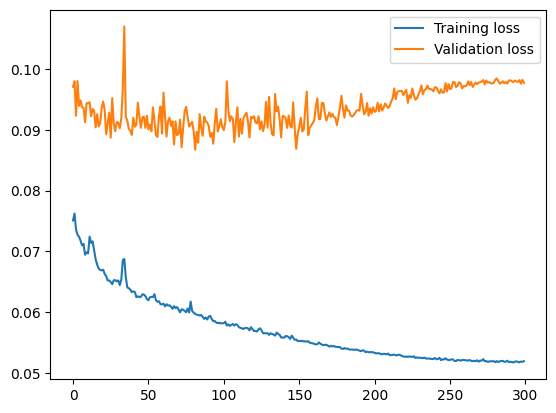

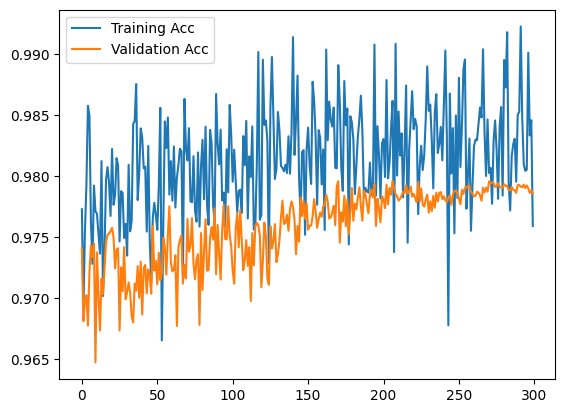

In [23]:

# Plot loss
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.savefig(save_dir+'loss.png')
# plot Acc
plt.figure()
plt.plot([i.item() for i in train_acc], label='Training Acc')
plt.plot([i.item() for i in val_acc], label='Validation Acc')
plt.legend()
plt.savefig(save_dir+'acc.png')

In [27]:
# hyperparameters
device = 'cuda'
epochs = 400
lr=5e-4
lr_end=1e-5

# create and load model
m=create_mobile_model().cuda()
load_model(m,"checkpoints/mobile/roadlane/best_model.pth")


# dataset
dataset_name = "labelme"
dataloaders, dataset_size = get_train_val_dataloader(4,0, type=dataset_name)
train_dataloader = dataloaders["train"]
val_dataloader = dataloaders["val"]
save_dir = f'checkpoints/mobile/{dataset_name}/'
os.makedirs(save_dir, exist_ok=True)
os.makedirs('out', exist_ok=True)
# loss and optimizer
weight=torch.tensor([1,1,1,1]).float().to(device)
criterion = nn.CrossEntropyLoss(weight)
optimizer = optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr_end)
# tensorboard
tb = SummaryWriter(f'runs/{dataset_name}')

print("dataset size:", dataset_size)

# TODO training loop
min_val_loss = float('inf')
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]


with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        # ================== training ==================
        m.train()
        running_loss = 0.0
        for iter, batch in enumerate(train_dataloader):
            images = batch['img'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = m(images)['out']
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss  = running_loss / len(train_dataloader)
        # record the loss
        tb.add_scalar('Loss/train', avg_train_loss, epoch)
        train_loss.append(avg_train_loss)
        train_acc.append(acc(outputs,labels).item())
        # ================== validation ==================
        m.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_dataloader:
                X_val = val_batch["img"].to(device)
                y_val = val_batch["label"].to(device)
                outputs_val = m(X_val)['out']
                running_val_loss += criterion(outputs_val, y_val).item()
                
                # svae the tmp output
                for i,img_out in enumerate(outputs_val):
                    _, predicted = torch.max(img_out, 0)
                    out=label_to_rgb(predicted, label_colors)
                    plt.imsave(f"out/e_{epoch}_i_{i}.jpg",out)

        avg_val_loss = running_val_loss / len(val_dataloader)
        # record the loss
        tb.add_scalar('Loss/val', avg_val_loss, epoch)
        val_loss.append(avg_val_loss)
        val_acc.append(acc(outputs_val,y_val).item())
        # ================== save ==================

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            print("the best model is updated !! from loss {} to {}".format(min_val_loss, avg_val_loss))
            save_model(m, save_dir+'best_model.pth')
        pbar.update(1)
        pbar.set_description(f"train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f} , train_acc: {train_acc[-1]:.4f}, val_acc: {val_acc[-1]:.4f}")
        scheduler.step()
            


dataset size: {'train': 27, 'val': 3}


  0%|          | 0/400 [00:00<?, ?it/s]

the best model is updated !! from loss 6.118076324462891 to 6.118076324462891
the best model is updated !! from loss 4.399057388305664 to 4.399057388305664
the best model is updated !! from loss 3.871359348297119 to 3.871359348297119
the best model is updated !! from loss 3.607003688812256 to 3.607003688812256
the best model is updated !! from loss 3.5370726585388184 to 3.5370726585388184
the best model is updated !! from loss 3.3349854946136475 to 3.3349854946136475
the best model is updated !! from loss 2.7639122009277344 to 2.7639122009277344
the best model is updated !! from loss 2.19126558303833 to 2.19126558303833
the best model is updated !! from loss 2.152371883392334 to 2.152371883392334
the best model is updated !! from loss 1.8401145935058594 to 1.8401145935058594
the best model is updated !! from loss 1.7882236242294312 to 1.7882236242294312
the best model is updated !! from loss 1.6579608917236328 to 1.6579608917236328
the best model is updated !! from loss 1.4594819545745

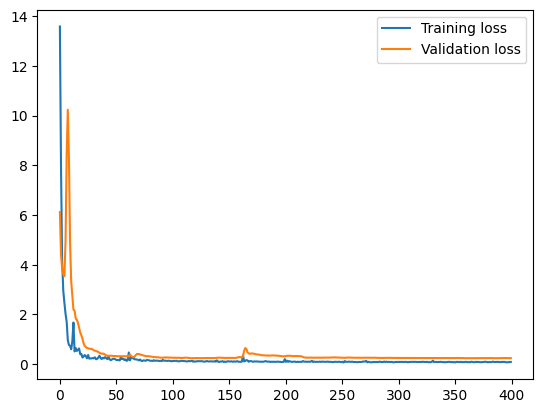

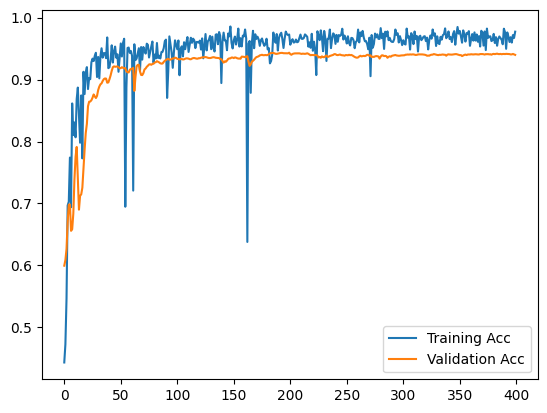

In [28]:

# Plot loss
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.savefig(save_dir+'loss.png')
# plot Acc
plt.figure()
plt.plot(train_acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.legend()
plt.savefig(save_dir+'acc.png')